In [54]:
import pandas as pd
import numpy as np

import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import cv2
import io
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
data = h5py.File('./Data/train-image.hdf5')
meta = pd.read_csv('./Data/train-metadata.csv', low_memory = False)

In [3]:
len(data)

401059

In [4]:
meta = meta[['isic_id', 'target']]
meta.shape

(401059, 2)

In [5]:
meta['isic_id'].nunique(), meta['target'].nunique(), meta['target'].value_counts()

(401059,
 2,
 target
 0    400666
 1       393
 Name: count, dtype: int64)

In [6]:
meta.isic_id.iloc[0]

'ISIC_0015670'

In [7]:
byte_string = data[meta.isic_id.iloc[0]][()]
byte_string[:20]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'

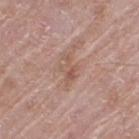

In [8]:
image = Image.open(io.BytesIO(byte_string))
image

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [10]:
img_tensor = transform(image)
img_tensor.shape

torch.Size([3, 224, 224])

In [25]:
class ImageDataSet(Dataset):
    def __init__(self, data, meta, transform = None):
        self.data = data
        self.meta = meta
        self.transform = transform
    
    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        imageKey = self.meta.isic_id.iloc[idx]
        target = self.meta.target.iloc[idx]
        imageBytes = self.data[imageKey][()]
        image = Image.open(io.BytesIO(imageBytes))
        image = transform(image)
        return image, target

In [26]:
dataset = ImageDataSet(data, meta)

In [27]:
len(dataset)

401059

In [39]:
for i, j in dataset:
    print(i.shape, j)
    break

torch.Size([3, 224, 224]) 0


In [103]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [104]:
model = ClassificationModel()

In [105]:
model(i)

tensor([0.0374], grad_fn=<ViewBackward0>)